

> **IMPORTING DATA**



In [3]:
from google.colab import files
import os

os.makedirs("data", exist_ok=True)

print("Please upload `corpus.txt` and `test.txt` when prompted...")
uploaded = files.upload()

for filename in uploaded.keys():
    os.rename(filename, f"data/{filename}")
    print(f"Uploaded: data/{filename}")

print("\nFiles in data/:")
!ls -lh data/

Please upload `corpus.txt` and `test.txt` when prompted...


Saving corpus.txt to corpus.txt
Saving test.txt to test.txt
Uploaded: data/corpus.txt
Uploaded: data/test.txt

Files in data/:
total 588K
-rw-r--r-- 1 root root 562K Nov  3 04:17 corpus.txt
-rw-r--r-- 1 root root  23K Nov  3 04:17 test.txt


**EXPLORING CORPUS.txt**

Loaded 48,597 words from corpus.txt
Example words: ['suburbanize', 'asmack', 'hypotypic', 'consonantly', 'philatelically', 'cacomelia', 'thicklips', 'luciferase', 'cinematography', 'selamlik']


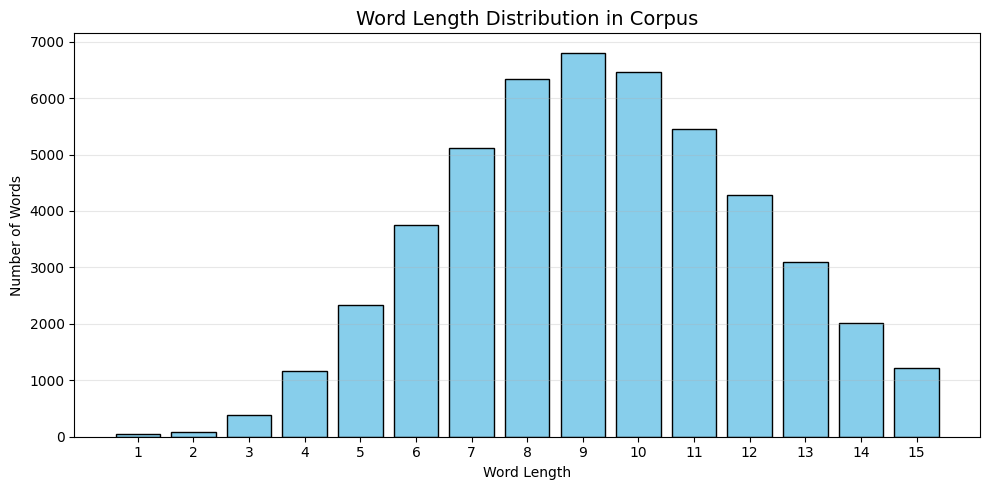

Most common word lengths: [11, 12, 13, 14, 15]


In [4]:
# 2.Load and Explore Corpus

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import pickle

# Load corpus
with open('data/corpus.txt', 'r') as f:
    corpus = [line.strip().lower() for line in f if line.strip() and len(line.strip()) <= 15]

print(f"Loaded {len(corpus):,} words from corpus.txt")
print(f"Example words: {corpus[:10]}")

# Word length distribution
length_counts = Counter(len(w) for w in corpus)
lengths = sorted(length_counts.keys())
counts = [length_counts[l] for l in lengths]

plt.figure(figsize=(10, 5))
plt.bar(lengths, counts, color='skyblue', edgecolor='black')
plt.title("Word Length Distribution in Corpus", fontsize=14)
plt.xlabel("Word Length")
plt.ylabel("Number of Words")
plt.xticks(lengths)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Most common word lengths: {lengths[-5:]}")

BUILDING HMM ORACLE

In [6]:
# 3. Build HMM Oracle

import numpy as np
from collections import defaultdict
import pickle
import os

class HMMOracle:
    def __init__(self, max_length=15):
        self.max_length = max_length
        self.models = {}
        self.vocab = 'abcdefghijklmnopqrstuvwxyz'
        self.char_to_idx = {c: i for i, c in enumerate(self.vocab)}

    def train(self, corpus):
        words_by_length = defaultdict(list)
        for word in corpus:
            if len(word) <= self.max_length:
                words_by_length[len(word)].append(word)

        print("Training one HMM per word length...")
        for length, words in sorted(words_by_length.items()):
            if len(words) < 10:
                continue

            #Emission counts with Laplace smoothing
            emit_count = np.ones((length, 26))

            for word in words:
                for pos, char in enumerate(word):
                    if char not in self.char_to_idx:
                        continue
                    idx = self.char_to_idx[char]
                    emit_count[pos, idx] += 1

            #Normalize to probabilities
            emit_prob = emit_count / emit_count.sum(axis=1, keepdims=True)

            self.models[length] = {'emit': emit_prob}

        print(f"Trained {len(self.models)} HMMs for lengths: {sorted(self.models.keys())}")

    def get_letter_probs(self, masked_word, guessed_letters=set()):
        length = len(masked_word)
        if length not in self.models:
            return np.ones(26) / 26

        emit = self.models[length]['emit']
        blank_pos = [i for i, c in enumerate(masked_word) if c == '_']

        if not blank_pos:
            return np.zeros(26)

        probs = np.mean([emit[i] for i in blank_pos], axis=0)

        for g in guessed_letters:
            if g in self.char_to_idx:
                probs[self.char_to_idx[g]] = 0

        total = probs.sum()
        return probs / total if total > 0 else np.ones(26)/26

    def save(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)
        print(f"Model saved to {path}")

hmm = HMMOracle()
hmm.train(corpus)
os.makedirs("models", exist_ok=True)
hmm.save("models/hmm_oracle.pkl")

Training one HMM per word length...
Trained 15 HMMs for lengths: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Model saved to models/hmm_oracle.pkl


TESTING HMM

Masked: h_ll_
Guessed: []
Top 5 letters: ['a', 'e', 'o', 'r', 'i'] → [0.14  0.135 0.1   0.07  0.069]


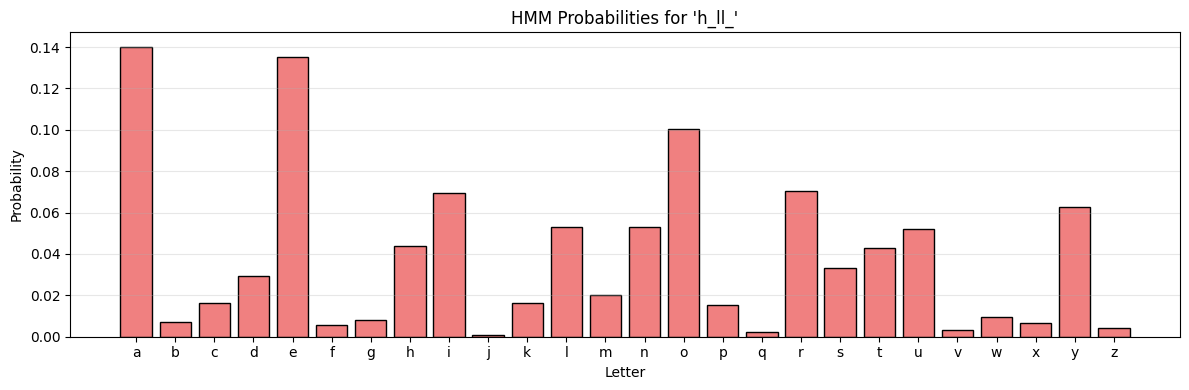

Masked: a_p_e
Guessed: ['x']
Top 5 letters: ['a', 'e', 'o', 'i', 'u'] → [0.137 0.116 0.095 0.091 0.078]


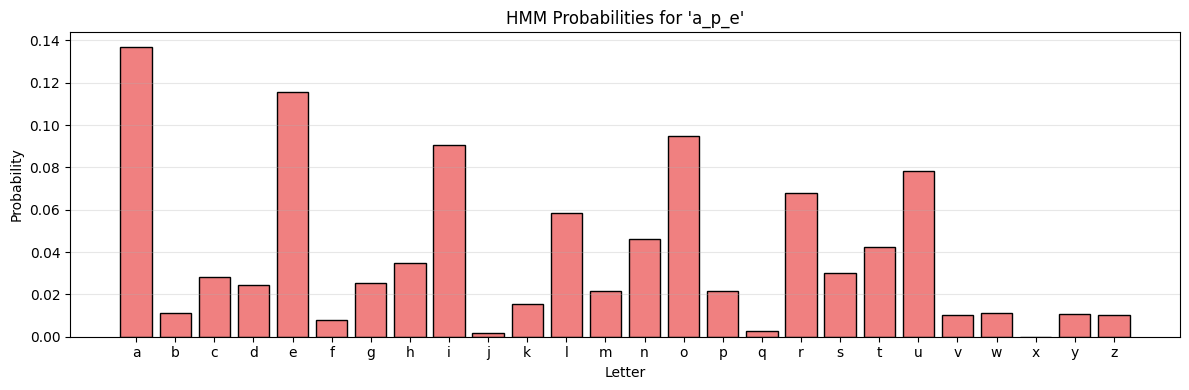

Masked: _ _ _ _ _
Guessed: []
Top 5 letters: ['e', 'i', 'a', 's', 'r'] → [0.108 0.089 0.078 0.069 0.067]


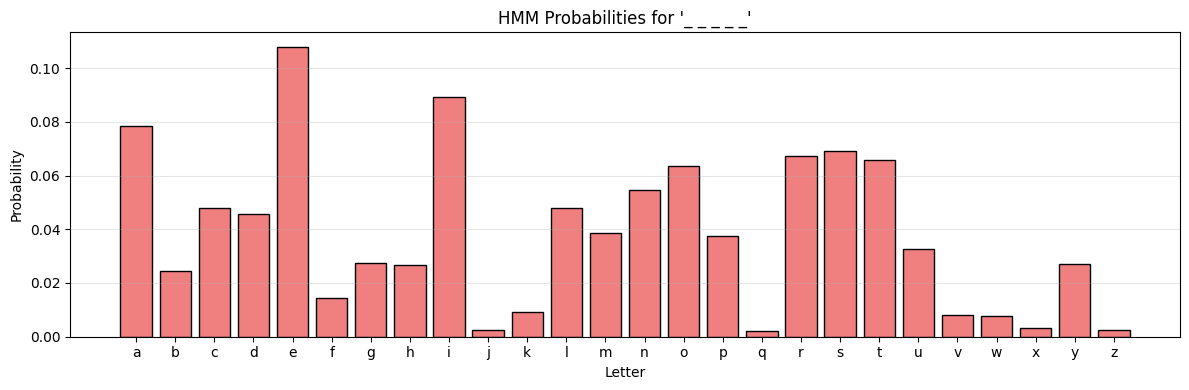

In [7]:
#4. Test HMM Oracle

def test_hmm(masked, guessed=[]):
    probs = hmm.get_letter_probs(masked, set(guessed))
    top5_idx = probs.argsort()[-5:][::-1]
    letters = [chr(97 + i) for i in top5_idx]
    values = probs[top5_idx]

    print(f"Masked: {masked}")
    print(f"Guessed: {guessed}")
    print(f"Top 5 letters: {letters} → {values.round(3)}")

    # Plot
    plt.figure(figsize=(12, 4))
    plt.bar(range(26), probs, color='lightcoral', edgecolor='black')
    plt.xticks(range(26), [chr(97+i) for i in range(26)])
    plt.title(f"HMM Probabilities for '{masked}'")
    plt.xlabel("Letter")
    plt.ylabel("Probability")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

#Test 1
test_hmm("h_ll_", [])

#Test 2
test_hmm("a_p_e", ['x'])

#Test 3
test_hmm("_ _ _ _ _", [])

**MODEL FILE**

In [10]:
#5. Download Model

from google.colab import files
files.download('models/hmm_oracle.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>